### Requirements

In [11]:
import os
import cv2
import random
import shutil
import numpy as np
from PIL import Image
from keras import optimizers
from keras.optimizers import Adam
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from sklearn.utils.class_weight import compute_class_weight
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.utils import class_weight
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.models import Model
from collections import defaultdict
from imblearn.over_sampling import RandomOverSampler
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetB0
from sklearn.metrics import classification_report, roc_auc_score
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler
import numpy as np




### Functions

This function loads the dataset

In [12]:
def load_dataset(base_path):

    train_folder = os.path.join(base_path, 'train')
    test_folder = os.path.join(base_path, 'test')
    val_folder = os.path.join(base_path, 'val')

    return train_folder, test_folder, val_folder

This function counts the number of images in each class

In [13]:
def info(train_folder, test_folder, val_folder):

    train_normal_count = len(os.listdir(os.path.join(train_folder, 'NORMAL')))
    train_pneumonia_count = len(os.listdir(os.path.join(train_folder, 'PNEUMONIA')))

    test_normal_count = len(os.listdir(os.path.join(test_folder, 'NORMAL')))
    test_pneumonia_count = len(os.listdir(os.path.join(test_folder, 'PNEUMONIA')))

    val_normal_count = len(os.listdir(os.path.join(val_folder, 'NORMAL')))
    val_pneumonia_count = len(os.listdir(os.path.join(val_folder, 'PNEUMONIA')))


    print("Dataset Information:")
    print("--------------------")
    print(f"Train - Normal: {train_normal_count} images")
    print(f"Train - Pneumonia: {train_pneumonia_count} images")
    print(f"Test - Normal: {test_normal_count} images")
    print(f"Test - Pneumonia: {test_pneumonia_count} images")
    print(f"Validation - Normal: {val_normal_count} images")
    print(f"Validation - Pneumonia: {val_pneumonia_count} images")


This function collects information about image sizes and formats within a given folder

In [4]:
def image_info(folder_path):
    image_sizes = []
    image_formats = set()

    for class_folder in os.listdir(folder_path):
        class_path = os.path.join(folder_path, class_folder)
        for image_file in os.listdir(class_path):
            image_path = os.path.join(class_path, image_file)
            with Image.open(image_path) as img:
                size = img.size
                if size not in image_sizes:
                    image_sizes.append(size)
                image_formats.add(img.format)

    return image_sizes, image_formats


 This function visualizes the class distribution of the dataset in bar plots

In [14]:
def class_distribution(train_folder, test_folder, val_folder):
    folders = {'Train': train_folder, 'Test': test_folder, 'Validation': val_folder}

    for folder_name, folder_path in folders.items():
        class_counts = {}

        for class_folder in os.listdir(folder_path):
            class_path = os.path.join(folder_path, class_folder)
            class_name = class_folder.upper()
            class_counts[class_name] = len(os.listdir(class_path))


        plt.figure(figsize=(8, 6))
        plt.bar(class_counts.keys(), class_counts.values())
        plt.title(f'Class Distribution - {folder_name}')
        plt.xlabel('Class')
        plt.ylabel('Count')
        plt.show()


This function displays a specified number of sample images

In [15]:
def samples(folder_path, class_name, num_samples=5):
    class_folder = os.path.join(folder_path, class_name)
    image_files = os.listdir(class_folder)
    sample_files = image_files[:num_samples]

    plt.figure(figsize=(15, 5))
    for i, file_name in enumerate(sample_files):
        image_path = os.path.join(class_folder, file_name)
        with Image.open(image_path) as img:
            plt.subplot(1, num_samples, i + 1)
            plt.imshow(img, cmap='gray')
            plt.axis('off')

    plt.suptitle(f'Sample Images - Class: {class_name}', fontsize=14)
    plt.show()

This function iterates through each class folder and removes any corrupted images or irrelevant files

In [16]:
def check_image(image_path):
    try:
        with Image.open(image_path) as img:
            img.verify()
        return True
    except (IOError, SyntaxError):
        return False

def clean_dataset(folder_path):
    for class_folder in os.listdir(folder_path):
        class_path = os.path.join(folder_path, class_folder)
        if os.path.isdir(class_path):
            for image_file in os.listdir(class_path):
                image_path = os.path.join(class_path, image_file)
                if not check_image(image_path):
                    os.remove(image_path)
                    print(f"Removed corrupted image: {image_path}")

        irrelevant_files = [file for file in os.listdir(class_path) if not file.endswith(".jpeg")]
        for file in irrelevant_files:
            file_path = os.path.join(class_path, file)
            if os.path.isfile(file_path):
                os.remove(file_path)
                print(f"Removed irrelevant file: {file_path}")


This function resizes all images in each class folder to a target size.

In [8]:
def resize_images(folder_path, target_size):
    for class_folder in os.listdir(folder_path):
        class_path = os.path.join(folder_path, class_folder)
        if os.path.isdir(class_path):
            for image_file in os.listdir(class_path):
                image_path = os.path.join(class_path, image_file)
                with Image.open(image_path) as img:
                    resized_img = img.resize(target_size)
                    resized_img.save(image_path)

This function normalizes the pixel values of the images to scale them between 0 and 1.

In [17]:
def normalize_images(folder_path):
    for class_folder in os.listdir(folder_path):
        class_path = os.path.join(folder_path, class_folder)
        if os.path.isdir(class_path):
            for image_file in os.listdir(class_path):
                image_path = os.path.join(class_path, image_file)
                with Image.open(image_path) as img:
                    img_array = np.array(img)
                    normalized_img_array = img_array / 255.0
                    normalized_img = Image.fromarray((normalized_img_array * 255).astype(np.uint8))
                    normalized_img.save(image_path)

This function define the first implementation of EfficientNet model

In [18]:
def train_model(train_folder, test_folder, target_size, epochs=10, batch_size=32):

    train_datagen = ImageDataGenerator(
        rescale=1.0/255.0,
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True
    )

    test_datagen = ImageDataGenerator(rescale=1.0/255.0)


    train_generator = train_datagen.flow_from_directory(
        train_folder,
        target_size=target_size,
        batch_size=batch_size,
        class_mode='binary',
        shuffle=True
    )

    test_generator = test_datagen.flow_from_directory(
        test_folder,
        target_size=target_size,
        batch_size=batch_size,
        class_mode='binary',
        shuffle=False
    )

    class_labels = np.unique(train_generator.classes)
    train_labels = train_generator.classes
    class_samples = [np.sum(train_labels == label) for label in class_labels]
    total_samples = np.sum(class_samples)
    num_classes = len(class_labels)
    class_weights = {class_labels[i]: total_samples / (num_classes * class_samples[i]) for i in range(num_classes)}

    base_model = EfficientNetB0(include_top=False, weights='imagenet', input_shape=(target_size[0], target_size[1], 3))


    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(1, activation='sigmoid')(x)


    model = Model(inputs=base_model.input, outputs=x)


    model.compile(loss='binary_crossentropy', optimizer=optimizers.Adam(), metrics=['accuracy'])


    model.fit(
        train_generator,
        steps_per_epoch=train_generator.samples // batch_size,
        epochs=epochs,
        class_weight=class_weights,
        validation_data=test_generator,
        validation_steps=test_generator.samples // batch_size
    )

This function Fine tunines the previous version

In [19]:
def train_model1(train_folder, test_folder, target_size, epochs=10, batch_size=32):

    train_datagen = ImageDataGenerator(
        rescale=1.0/255.0,
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True
    )

    test_datagen = ImageDataGenerator(rescale=1.0/255.0)


    train_generator = train_datagen.flow_from_directory(
        train_folder,
        target_size=target_size,
        batch_size=batch_size,
        class_mode='binary',
        shuffle=True
    )

    test_generator = test_datagen.flow_from_directory(
        test_folder,
        target_size=target_size,
        batch_size=batch_size,
        class_mode='binary',
        shuffle=False
    )


    class_labels = np.unique(train_generator.classes)
    train_labels = train_generator.classes
    class_samples = [np.sum(train_labels == label) for label in class_labels]
    total_samples = np.sum(class_samples)
    num_classes = len(class_labels)
    class_weights = {class_labels[i]: total_samples / (num_classes * class_samples[i]) for i in range(num_classes)}

    base_model = EfficientNetB0(include_top=False, weights='imagenet', input_shape=(target_size[0], target_size[1], 3))

    # Freeze all layers in the base model
    base_model.trainable = False

    # Add a global average pooling layer and a dense layer
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(1, activation='sigmoid')(x)

    # Create the model
    model = Model(inputs=base_model.input, outputs=x)

    model.compile(loss='binary_crossentropy', optimizer=optimizers.Adam(), metrics=['accuracy'])

    model.fit(
        train_generator,
        steps_per_epoch=train_generator.samples // batch_size,
        epochs=epochs,
        class_weight=class_weights,
        validation_data=test_generator,
        validation_steps=test_generator.samples // batch_size
    )

    # Unfreeze some layers in the base model for fine-tuning
    unfreeze_layers = 100  #the number of layers to unfreeze
    for layer in base_model.layers[-unfreeze_layers:]:
        if not isinstance(layer, BatchNormalization):
            layer.trainable = True

    model.compile(loss='binary_crossentropy', optimizer=optimizers.Adam(lr=0.0001), metrics=['accuracy'])

    # Fine-tune the model
    model.fit(
        train_generator,
        steps_per_epoch=train_generator.samples // batch_size,
        epochs=epochs,
        class_weight=class_weights,
        validation_data=test_generator,
        validation_steps=test_generator.samples // batch_size
    )

    return model

Further improvement

In [20]:
def train_model2(train_folder, test_folder, target_size, epochs=10, batch_size=32):

    train_datagen = ImageDataGenerator(
        rescale=1.0/255.0,
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True
    )

    test_datagen = ImageDataGenerator(rescale=1.0/255.0)

    train_generator = train_datagen.flow_from_directory(
        train_folder,
        target_size=target_size,
        batch_size=batch_size,
        class_mode='binary',
        shuffle=True
    )

    test_generator = test_datagen.flow_from_directory(
        test_folder,
        target_size=target_size,
        batch_size=batch_size,
        class_mode='binary',
        shuffle=False
    )

    class_labels = np.unique(train_generator.classes)
    train_labels = train_generator.classes
    class_samples = [np.sum(train_labels == label) for label in class_labels]
    total_samples = np.sum(class_samples)
    num_classes = len(class_labels)
    class_weights = {class_labels[i]: total_samples / (num_classes * class_samples[i]) for i in range(num_classes)}
    base_model = EfficientNetB0(include_top=False, weights='imagenet', input_shape=(target_size[0], target_size[1], 3))

    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(1, activation='sigmoid')(x)

    model = Model(inputs=base_model.input, outputs=x)

    # Unfreeze layers for fine-tuning
    unfreeze_layers = 150  #  the number of layers to unfreeze
    for layer in base_model.layers[-unfreeze_layers:]:
        if not isinstance(layer, tf.keras.layers.BatchNormalization):
            layer.trainable = True

    #  a lower learning rate
    optimizer = optimizers.Adam(learning_rate=0.0001)
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

    # early stopping callback
    early_stopping = EarlyStopping(patience=3, restore_best_weights=True)

    #
    model.fit(
        train_generator,
        steps_per_epoch=train_generator.samples // batch_size,
        epochs=epochs,
        class_weight=class_weights,
        validation_data=test_generator,
        validation_steps=test_generator.samples // batch_size,
        callbacks=[early_stopping]
    )

    return model

Final version

In [21]:
def step_decay(epoch):
    initial_lr = 0.001
    drop_factor = 0.5
    epochs_drop = 5
    return initial_lr * np.power(drop_factor, np.floor((1 + epoch) / epochs_drop))

def train_model_improved(train_folder, test_folder, target_size, epochs=20, batch_size=32):
    train_datagen = ImageDataGenerator(
        rescale=1.0/255.0,
        rotation_range=30,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True
    )

    test_datagen = ImageDataGenerator(rescale=1.0/255.0)

    train_generator = train_datagen.flow_from_directory(
        train_folder,
        target_size=target_size,
        batch_size=batch_size,
        class_mode='binary',
        shuffle=True
    )

    test_generator = test_datagen.flow_from_directory(
        test_folder,
        target_size=target_size,
        batch_size=batch_size,
        class_mode='binary',
        shuffle=False
    )

    class_labels = np.unique(train_generator.classes)
    train_labels = train_generator.classes
    class_samples = [np.sum(train_labels == label) for label in class_labels]
    total_samples = np.sum(class_samples)
    num_classes = len(class_labels)
    class_weights = {class_labels[i]: total_samples / (num_classes * class_samples[i]) for i in range(num_classes)}


    base_model = EfficientNetB0(include_top=False, weights='imagenet', input_shape=(target_size[0], target_size[1], 3))

    # Add a global average pooling layer and a dense layer
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(1, activation='sigmoid')(x)


    model = Model(inputs=base_model.input, outputs=x)

    # Unfreeze layers for fine-tuning
    unfreeze_layers = 200  #
    for layer in base_model.layers[-unfreeze_layers:]:
        if not isinstance(layer, tf.keras.layers.BatchNormalization):
            layer.trainable = True

    # Compile the model with RMSprop
    optimizer = optimizers.RMSprop(learning_rate=0.001)
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

    #  early stopping callback
    early_stopping = EarlyStopping(patience=5, restore_best_weights=True)

    #  learning rate scheduler callback
    lr_scheduler = LearningRateScheduler(step_decay)

    #
    model.fit(
        train_generator,
        steps_per_epoch=train_generator.samples // batch_size,
        epochs=epochs,
        class_weight=class_weights,
        validation_data=test_generator,
        validation_steps=test_generator.samples // batch_size,
        callbacks=[early_stopping, lr_scheduler]
    )

    return model


MobileNet Model

In [22]:
def train_mobile(train_folder, test_folder, target_size, epochs=10, batch_size=32):
    train_datagen = ImageDataGenerator(
        rescale=1.0/255.0,
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True
    )

    test_datagen = ImageDataGenerator(rescale=1.0/255.0)
    train_generator = train_datagen.flow_from_directory(
        train_folder,
        target_size=target_size,
        batch_size=batch_size,
        class_mode='binary',
        shuffle=True
    )

    test_generator = test_datagen.flow_from_directory(
        test_folder,
        target_size=target_size,
        batch_size=batch_size,
        class_mode='binary',
        shuffle=False
    )

    # Calculate class weights
    class_labels = np.unique(train_generator.classes)
    train_labels = train_generator.classes
    class_samples = [np.sum(train_labels == label) for label in class_labels]
    total_samples = np.sum(class_samples)
    num_classes = len(class_labels)
    class_weights = {class_labels[i]: total_samples / (num_classes * class_samples[i]) for i in range(num_classes)}

    base_model = MobileNetV2(include_top=False, weights='imagenet', input_shape=(target_size[0], target_size[1], 3))

    # Add a global average pooling layer and a dense layer
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(1, activation='sigmoid')(x)


    model = Model(inputs=base_model.input, outputs=x)


    model.compile(loss='binary_crossentropy', optimizer=optimizers.Adam(learning_rate=0.001), metrics=['accuracy'])


    model.fit(
        train_generator,
        steps_per_epoch=train_generator.samples // batch_size,
        epochs=epochs,
        class_weight=class_weights,
        validation_data=test_generator,
        validation_steps=test_generator.samples // batch_size
    )

MobileNet Improvement

### Load the dataset

In [23]:
base_path = '/content/drive/MyDrive/chest_xray'
train_folder, test_folder, val_folder = load_dataset(base_path)


### Information

basic info

In [34]:
info(train_folder, test_folder, val_folder)

Dataset Information:
--------------------
Train - Normal: 1341 images
Train - Pneumonia: 3875 images
Test - Normal: 234 images
Test - Pneumonia: 390 images
Validation - Normal: 8 images
Validation - Pneumonia: 8 images


image size

In [25]:
# Get image info
train_sizes, train_formats =image_info(train_folder)
test_sizes, test_formats = image_info(test_folder)
val_sizes, val_formats =image_info(val_folder)

# Print the info
print("Image Information:")
print("------------------")
print("Train Set:")
print(f"Image Sizes: {train_sizes}")
print(f"Image Formats: {train_formats}")
print("Test Set:")
print(f"Image Sizes: {test_sizes}")
print(f"Image Formats: {test_formats}")
print("Validation Set:")
print(f"Image Sizes: {val_sizes}")
print(f"Image Formats: {val_formats}")


Image Information:
------------------
Train Set:
Image Sizes: [(224, 224)]
Image Formats: {'JPEG'}
Test Set:
Image Sizes: [(224, 224)]
Image Formats: {'JPEG'}
Validation Set:
Image Sizes: [(224, 224)]
Image Formats: {'JPEG'}


class imbalance

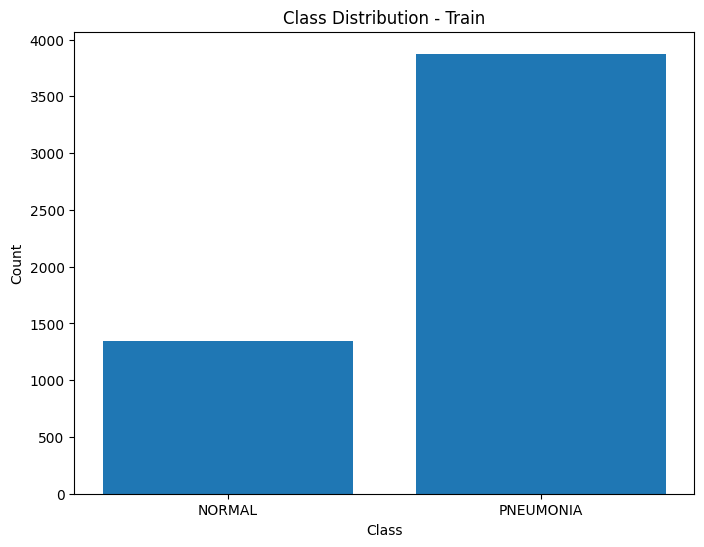

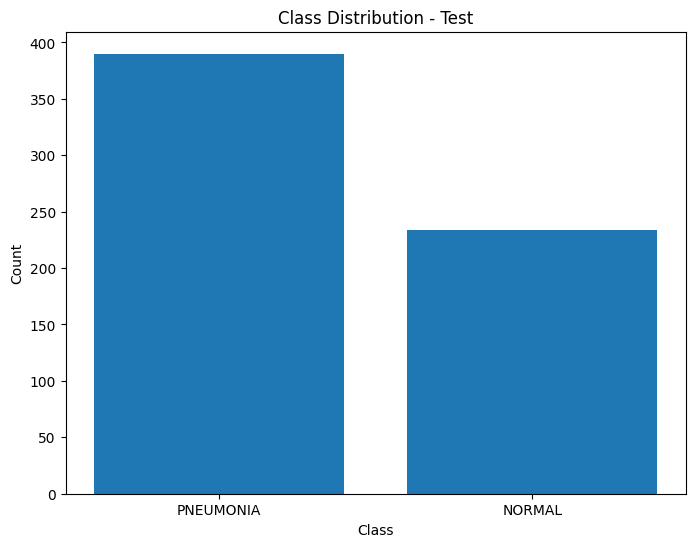

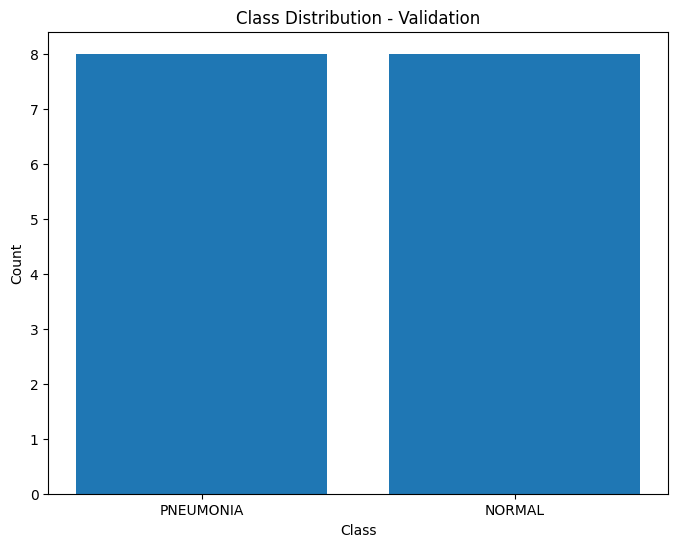

In [26]:
class_distribution(train_folder, test_folder, val_folder)

sample

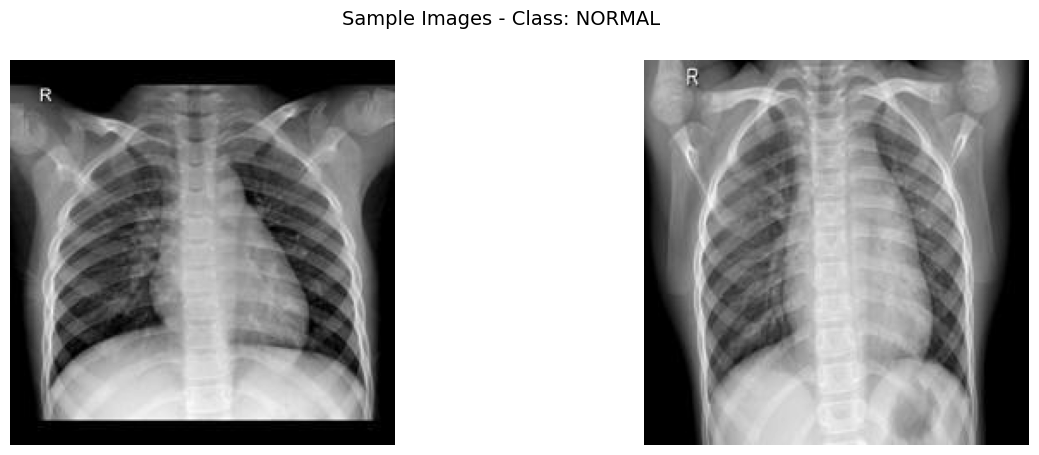

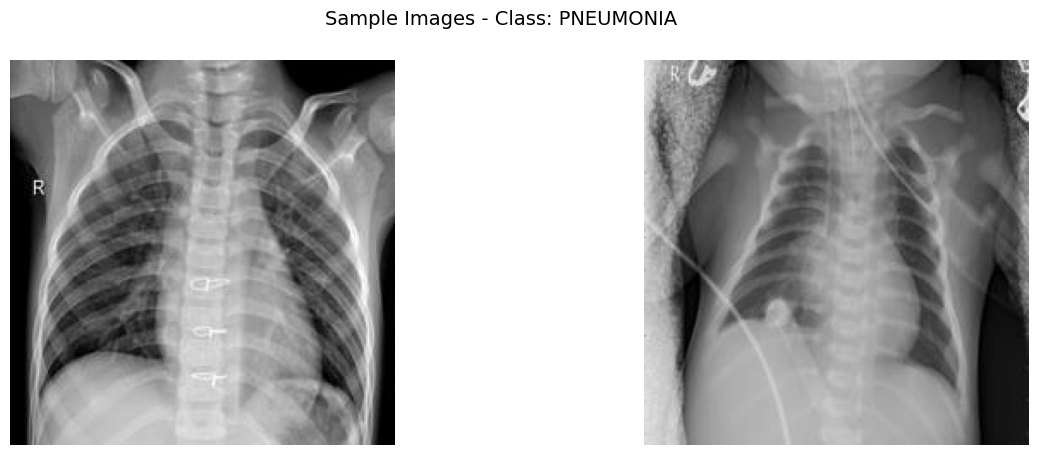

In [ ]:
samples(train_folder, 'NORMAL', num_samples=2)
samples(train_folder, 'PNEUMONIA', num_samples=2)

### Preprocessing

Data cleaning

In [27]:
clean_dataset(train_folder)
clean_dataset(test_folder)
clean_dataset( val_folder)

Resize

In [28]:
target_size = (224, 224)
resize_images(train_folder, target_size)
resize_images(test_folder, target_size)
resize_images(val_folder, target_size)

Normalie

In [29]:
normalize_images(train_folder)
normalize_images(test_folder)
normalize_images(val_folder)

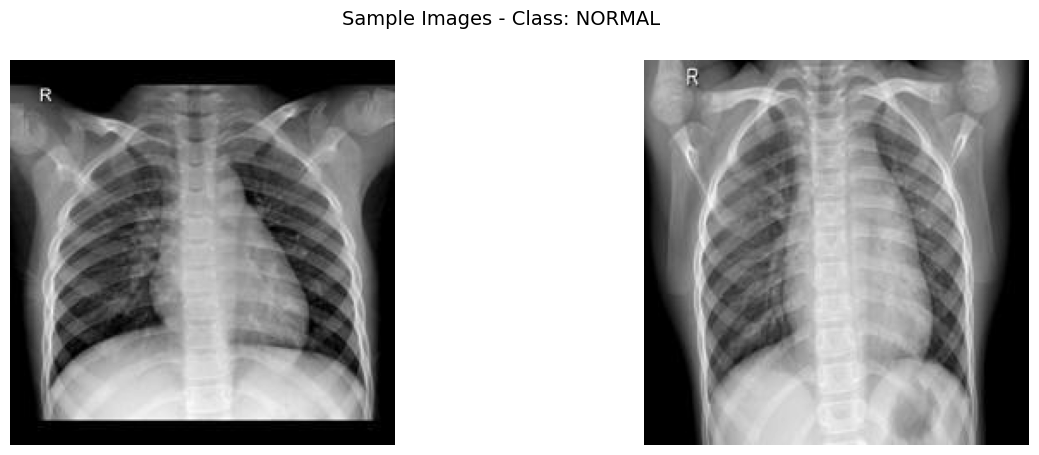

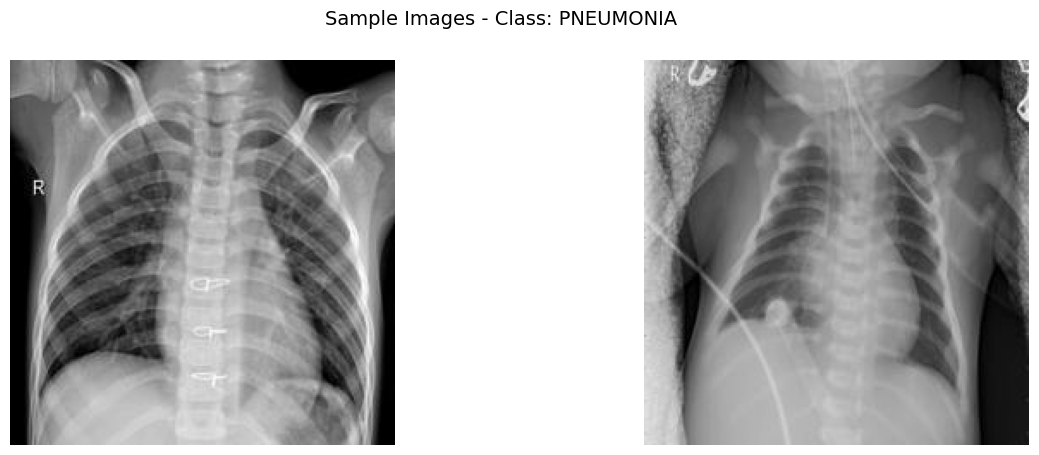

In [ ]:
samples(train_folder, 'NORMAL', num_samples=2)
samples(train_folder, 'PNEUMONIA', num_samples=2)

In [ ]:
info(train_folder, test_folder, val_folder)

Dataset Information:
--------------------
Train - Normal: 1341 images
Train - Pneumonia: 3875 images
Test - Normal: 234 images
Test - Pneumonia: 390 images
Validation - Normal: 8 images
Validation - Pneumonia: 8 images


## Models

### EfficientNetB0-train_model

In [ ]:
target_size = (224, 224)
EfficientNet = train_model(train_folder, test_folder, target_size, epochs=10, batch_size=32)

Found 5216 images belonging to 2 classes.
Found 624 images belonging to 2 classes.
Epoch 1/10
163/163 [==============================] - 75s 404ms/step - loss: 0.2156 - accuracy: 0.9105 - val_loss: 0.9013 - val_accuracy: 0.6151
Epoch 2/10
163/163 [==============================] - 65s 396ms/step - loss: 0.1462 - accuracy: 0.9427 - val_loss: 0.6545 - val_accuracy: 0.6151
Epoch 3/10
163/163 [==============================] - 65s 395ms/step - loss: 0.1134 - accuracy: 0.9565 - val_loss: 0.5396 - val_accuracy: 0.6349
Epoch 4/10
163/163 [==============================] - 65s 395ms/step - loss: 0.0984 - accuracy: 0.9615 - val_loss: 13.7219 - val_accuracy: 0.5197
Epoch 5/10
163/163 [==============================] - 64s 394ms/step - loss: 0.0900 - accuracy: 0.9641 - val_loss: 0.9487 - val_accuracy: 0.6151
Epoch 6/10
163/163 [==============================] - 65s 397ms/step - loss: 0.0739 - accuracy: 0.9724 - val_loss: 7.8600 - val_accuracy: 0.4523
Epoch 7/10
163/163 [==========================

fine tune train_model1

In [31]:
target_size = (224, 224)
EfficientNet = train_model1(train_folder, test_folder, target_size, epochs=10, batch_size=32)

Found 5216 images belonging to 2 classes.
Found 624 images belonging to 2 classes.
Epoch 1/10
163/163 [==============================] - 84s 455ms/step - loss: 0.7000 - accuracy: 0.4875 - val_loss: 0.6962 - val_accuracy: 0.3849
Epoch 2/10
163/163 [==============================] - 71s 438ms/step - loss: 0.7003 - accuracy: 0.5203 - val_loss: 0.7001 - val_accuracy: 0.3849
Epoch 3/10
163/163 [==============================] - 72s 440ms/step - loss: 0.6985 - accuracy: 0.5010 - val_loss: 0.7069 - val_accuracy: 0.3849
Epoch 4/10
163/163 [==============================] - 72s 440ms/step - loss: 0.6992 - accuracy: 0.4780 - val_loss: 0.6908 - val_accuracy: 0.6151
Epoch 5/10
163/163 [==============================] - 73s 449ms/step - loss: 0.6975 - accuracy: 0.5265 - val_loss: 0.6976 - val_accuracy: 0.3849
Epoch 6/10
163/163 [==============================] - 73s 448ms/step - loss: 0.6989 - accuracy: 0.4908 - val_loss: 0.7107 - val_accuracy: 0.3849
Epoch 7/10
163/163 [===========================

Epoch 1/10
163/163 [==============================] - 91s 455ms/step - loss: 0.7226 - accuracy: 0.5075 - val_loss: 0.6940 - val_accuracy: 0.3849
Epoch 2/10
163/163 [==============================] - 75s 457ms/step - loss: 0.6933 - accuracy: 0.4803 - val_loss: 0.6933 - val_accuracy: 0.3849
Epoch 3/10
163/163 [==============================] - 74s 454ms/step - loss: 0.6932 - accuracy: 0.5993 - val_loss: 0.6929 - val_accuracy: 0.6151
Epoch 4/10
163/163 [==============================] - 74s 455ms/step - loss: 0.6932 - accuracy: 0.3240 - val_loss: 0.6932 - val_accuracy: 0.3849
Epoch 5/10
163/163 [==============================] - 74s 453ms/step - loss: 0.6932 - accuracy: 0.6641 - val_loss: 0.6928 - val_accuracy: 0.6151
Epoch 6/10
163/163 [==============================] - 75s 458ms/step - loss: 0.6932 - accuracy: 0.7431 - val_loss: 0.6931 - val_accuracy: 0.6151
Epoch 7/10
163/163 [==============================] - 74s 452ms/step - loss: 0.6932 - accuracy: 0.6102 - val_loss: 0.6933 - val_ac

Train_model2

In [ ]:
target_size = (224, 224)
EfficientNet = train_model2(train_folder, test_folder, target_size, epochs=20, batch_size=32)

Found 5216 images belonging to 2 classes.
Found 624 images belonging to 2 classes.
Epoch 1/20
163/163 [==============================] - 76s 408ms/step - loss: 0.2473 - accuracy: 0.8992 - val_loss: 0.6759 - val_accuracy: 0.6217
Epoch 2/20
163/163 [==============================] - 65s 395ms/step - loss: 0.1399 - accuracy: 0.9454 - val_loss: 0.6669 - val_accuracy: 0.6151
Epoch 3/20
163/163 [==============================] - 64s 390ms/step - loss: 0.1224 - accuracy: 0.9553 - val_loss: 0.7094 - val_accuracy: 0.6151
Epoch 4/20
163/163 [==============================] - 64s 390ms/step - loss: 0.0982 - accuracy: 0.9615 - val_loss: 0.9043 - val_accuracy: 0.6151
Epoch 5/20
163/163 [==============================] - 63s 387ms/step - loss: 0.0856 - accuracy: 0.9666 - val_loss: 12.1659 - val_accuracy: 0.6168


Final Version

In [ ]:
target_size = (224, 224)

EfficientNet = train_model_improved(train_folder, test_folder, target_size, epochs=20, batch_size=32)


Found 5216 images belonging to 2 classes.
Found 624 images belonging to 2 classes.
16705208/16705208 [==============================] - 2s 0us/step
Epoch 1/20
163/163 [==============================] - 112s 433ms/step - loss: 0.2225 - accuracy: 0.9024 - val_loss: 1.5954 - val_accuracy: 0.6151 - lr: 0.0010
Epoch 2/20
163/163 [==============================] - 71s 432ms/step - loss: 0.1373 - accuracy: 0.9454 - val_loss: 1.8828 - val_accuracy: 0.6151 - lr: 0.0010
Epoch 3/20
163/163 [==============================] - 70s 429ms/step - loss: 0.1158 - accuracy: 0.9544 - val_loss: 2.6917 - val_accuracy: 0.6151 - lr: 0.0010
Epoch 4/20
163/163 [==============================] - 69s 421ms/step - loss: 0.0957 - accuracy: 0.9628 - val_loss: 20.4712 - val_accuracy: 0.6151 - lr: 0.0010
Epoch 5/20
163/163 [==============================] - 69s 422ms/step - loss: 0.0650 - accuracy: 0.9741 - val_loss: 4.2138 - val_accuracy: 0.6151 - lr: 5.0000e-04
Epoch 6/20
163/163 [==============================] - 69

### MobileNet

In [ ]:
target_size = (224, 224)
MobiletNet = train_mobile(train_folder, test_folder, target_size, epochs=20, batch_size=32)

Found 5216 images belonging to 2 classes.
Found 624 images belonging to 2 classes.
Epoch 1/20
163/163 [==============================] - 66s 376ms/step - loss: 0.2249 - accuracy: 0.9120 - val_loss: 6.6425 - val_accuracy: 0.6151
Epoch 2/20
163/163 [==============================] - 60s 369ms/step - loss: 0.1410 - accuracy: 0.9467 - val_loss: 1.8203 - val_accuracy: 0.7188
Epoch 3/20
163/163 [==============================] - 60s 370ms/step - loss: 0.1287 - accuracy: 0.9454 - val_loss: 9.8204 - val_accuracy: 0.3849
Epoch 4/20
163/163 [==============================] - 60s 369ms/step - loss: 0.1104 - accuracy: 0.9572 - val_loss: 8.8759 - val_accuracy: 0.3849
Epoch 5/20
163/163 [==============================] - 60s 369ms/step - loss: 0.1125 - accuracy: 0.9563 - val_loss: 1.0242 - val_accuracy: 0.7714
Epoch 6/20
163/163 [==============================] - 61s 374ms/step - loss: 0.1109 - accuracy: 0.9563 - val_loss: 1.1346 - val_accuracy: 0.6678
Epoch 7/20
163/163 [===========================